<a href="https://colab.research.google.com/github/GermanOmar/LPBF/blob/master/RD316_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting the relative density of stainless steel and aluminum alloys manufactured by L-PBF using machine learning

<a href="https://ibb.co/3vvDZtg"><img src="https://i.ibb.co/Nrr8Bwc/Tests2-TIFF.png" WIDTH="620" HEIGHT="360"  border="0"></a>

 Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install lazypredict
warnings.filterwarnings("ignore")

Randomized search

In [3]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

 Upload database:

In [7]:
!git clone https://github.com/GermanOmar/LPBF

Cloning into 'LPBF'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 23.14 KiB | 4.63 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [8]:
#Experimental data
data = pd.read_table('/content/LPBF/DataSS.txt')
data.describe()


,Power,Speed,Hatch,Thickness,Spot,Energy,PSD,Atmosphere,Geometry,Strategy,RD
count,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000
mean,163.572289,828.630301,0.085015,0.043042,0.075934,109.271145,30.365181,3.786145,1.921687,4.575301,96.329006
std,56.139085,528.600764,0.026151,0.061488,0.031883,110.717403,6.777628,2.917711,1.025305,2.119623,3.752453
min,30.000000,18.760000,0.018000,0.020000,0.035000,21.370000,14.630000,1.000000,1.000000,1.000000,85.100000
25%,125.000000,498.500000,0.070000,0.030000,0.050000,59.390000,26.000000,1.000000,1.000000,3.000000,94.985000
50%,150.000000,800.000000,0.080000,0.030000,0.070000,83.330000,30.000000,2.000000,1.500000,4.000000,97.740000
75%,200.000000,1000.000000,0.110000,0.040000,0.080000,122.397500,35.500000,7.000000,3.000000,7.000000,99.082500
max,350.000000,3400.000000,0.160000,0.460000,0.200000,1295.610000,46.000000,7.000000,4.000000,7.000000,99.990000


In [13]:
df = data.copy()
df.head()

,Power,Speed,Hatch,Thickness,Spot,Energy,PSD,Atmosphere,Geometry,Strategy,RD
0,200.0,800.0,0.10,0.03,0.07,83.33,35.5,1,2,1,99.99
1,275.0,1000.0,0.12,0.03,0.07,76.39,35.5,1,2,1,99.98
2,350.0,1200.0,0.12,0.03,0.07,81.02,35.5,1,2,1,99.98
3,200.0,800.0,0.08,0.03,0.07,104.17,35.5,1,2,1,99.98
4,200.0,800.0,0.12,0.03,0.07,69.44,35.5,1,2,1,99.97


In [14]:
print(df.isna().any())

Power         False
Speed         False
Hatch         False
Thickness     False
Spot          False
Energy        False
PSD           False
Atmosphere    False
 Geometry     False
 Strategy     False
RD            False
dtype: bool


# Mutual information

In [17]:
# Mutual Information
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

X = df.iloc[:, :-1]
y = df.iloc[:, -1].values.reshape(-1,1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_zscored = scaler.fit_transform(y)
y = y_zscored.flatten()
X = X_scaled
mi = mutual_info_regression(X, y)

mi_df = pd.DataFrame({
    'Feature': data.columns[:-1],
    'Mutual Information': mi
})

mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
print(mi_df)

      Feature  Mutual Information
6        PSD             0.726757
9    Strategy            0.494573
2      Hatch             0.482447
4        Spot            0.426094
0       Power            0.409511
8    Geometry            0.304151
1      Speed             0.250164
5      Energy            0.232157
7  Atmosphere            0.226549
3   Thickness            0.202285


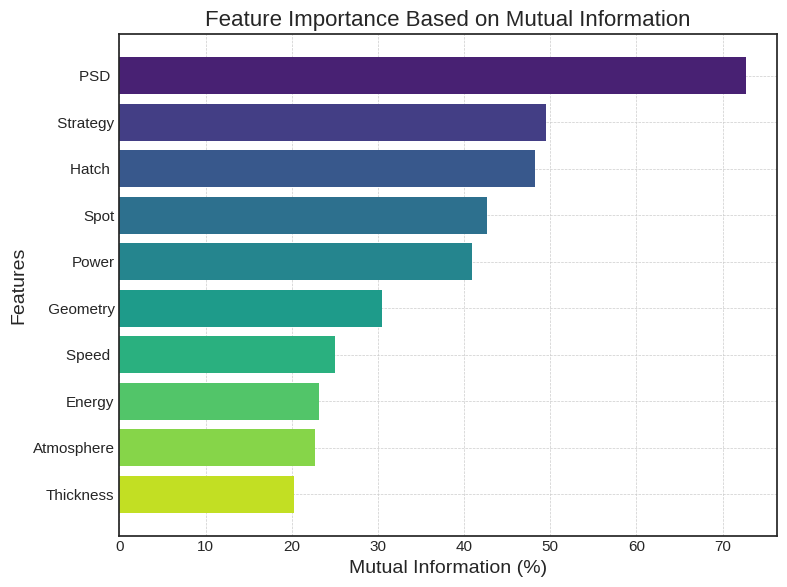

In [53]:
# Plotting
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11

import seaborn as sns

plt.style.use('seaborn-v0_8-white')
palette = sns.color_palette("viridis", len(mi_df))
plt.figure(figsize=(8, 6))
plt.barh(mi_df['Feature'], mi_df['Mutual Information']*100, color=palette)
plt.xlabel('Mutual Information (%)', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Feature Importance Based on Mutual Information', fontsize=16)
plt.gca().invert_yaxis()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Setting inputs - output:

In [21]:
#X=data[['P', 'S', 'L',  'HD1',  'F', 'd' ]]
X=data[['Power', 'Speed ', 'Hatch ',  'Thickness', 'Spot', 'Energy', 'PSD ', 'Atmosphere', ' Geometry', ' Strategy']]
Y = data['RD'].values.reshape(-1, 1)

# RD prediction

 Split data

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print('training samples:', X_train.shape[0],  ' test samples:', X_test.shape[0])

training samples: 265  test samples: 67


In [23]:
YTR=np.mean(y_train)
YTR

96.27588679245284

In [24]:
YT=np.mean(y_test)
YT

96.53910447761194

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#y_train = scaler.fit_transform(y_train)
#y_test = scaler.transform(y_test)


###Results:

In [26]:
from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle

In [27]:
from sklearn.metrics import mean_absolute_error as MAE
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None)
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 42/42 [00:01<00:00, 21.85it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 199
[LightGBM] [Info] Number of data points in the train set: 265, number of used features: 10
[LightGBM] [Info] Start training from score 96.275887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [30]:
#---------Scikit-learn Utilities---------------------------------------------------------------------------------------------
from sklearn.metrics import r2_score as R2
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor

### XGB

In [28]:
import pickle
import xgboost as xgb

# Change missing=None to missing=np.nan
# Assuming you want to use np.nan for missing values
import numpy as np

xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=20, min_child_weight=1, missing=np.nan, n_estimators=1000, # Changed missing value to np.nan
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

In [43]:
y_train_pred = xgbr.predict(X_train)
y_test_pred = xgbr.predict(X_test)

y_pred_train = xgbr.predict(X_train)
y_pred_test = xgbr.predict(X_test)

In [37]:
MSE_train = MSE(y_train, y_train_pred)
MSE_test = MSE(y_test, y_test_pred)
r2_train = R2(y_train, y_train_pred)
r2_test = R2(y_test, y_test_pred)
mae_train = MAE(y_train, y_train_pred)
mae_test = MAE(y_test, y_test_pred)

print('-'*100)
print(f'Error Metrics')
print(f'Training: MAE={mae_train:.4f}, MSE={MSE_train:.4f}, R2={r2_train:.4f}')
print(f'Testing: MAE={mae_test:.4f}, MSE={MSE_test:.4f}, R2={r2_test:.4f}')
print('-'*100)

----------------------------------------------------------------------------------------------------
Error Metrics
Training: MAE=0.1817, MSE=0.2392, R2=0.9830
Testing: MAE=0.9553, MSE=2.4860, R2=0.8222
----------------------------------------------------------------------------------------------------


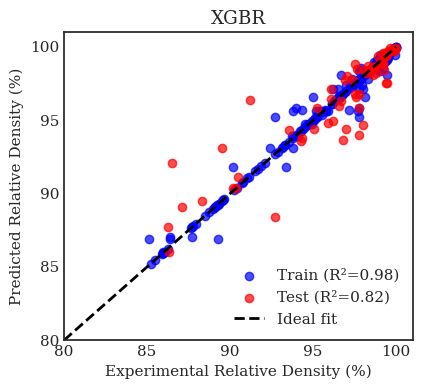

In [61]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11

fig, axes = plt.subplots(1, 1, figsize=(4.5, 4), sharex=True, sharey=True)

ax = axes
ax.scatter(y_train, y_pred_train, label=f"Train (R²={r2_train:.2f})", alpha=0.7, color='blue')
ax.scatter(y_test, y_pred_test, label=f"Test (R²={r2_test:.2f})", alpha=0.7, color='red')
ax.plot([80, 100], [80, 100], 'k--', lw=2, label='Ideal fit')

ax.set_title("XGBR")
ax.set_xlabel("Experimental Relative Density (%)")
ax.set_ylabel("Predicted Relative Density (%)")

ax.set_ylim(80, 101)
ax.set_xlim(80, 101)
ax.set_yticks(range(80, 101, 5))
ax.set_xticks(range(80, 101, 5))
ax.legend(loc='lower right')

plt.show()

In [56]:
# get importance

importance = xgbr.feature_importances_
# summarize feature importance

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance


Feature: 0, Score: 0.01411
Feature: 1, Score: 0.00538
Feature: 2, Score: 0.01388
Feature: 3, Score: 0.00782
Feature: 4, Score: 0.04918
Feature: 5, Score: 0.02287
Feature: 6, Score: 0.13737
Feature: 7, Score: 0.07055
Feature: 8, Score: 0.56194
Feature: 9, Score: 0.11690


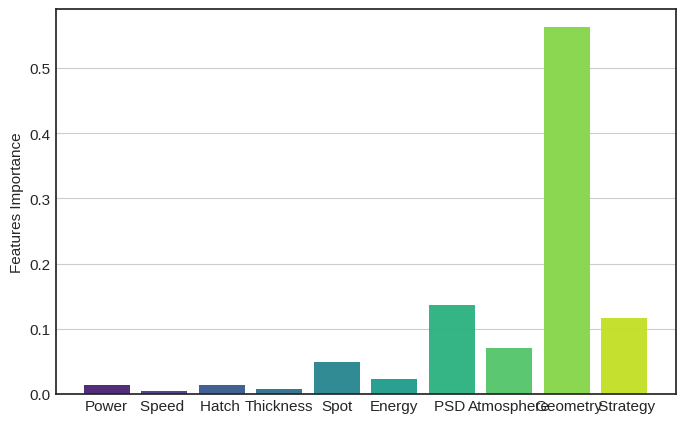

In [59]:
# Create lists for the plot
import seaborn as sns

plt.style.use('seaborn-v0_8-white')
palette = sns.color_palette("viridis", len(mi_df))

#plt.rcParams["axes.grid"] = False

labels = ['Power', 'Speed ', 'Hatch ',  'Thickness', 'Spot', 'Energy', 'PSD ', 'Atmosphere', ' Geometry', ' Strategy']
x_pos = np.arange(len(labels))

fig, ax = plt.subplots()
fig.set_size_inches((8,5))

ax.bar(x_pos, importance, align='center', alpha=0.95, color=palette)
ax.set_ylabel('Features Importance')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
#ax.set_title('Features Importance Analysis')
ax.yaxis.grid(True)


## GBR

In [65]:
from sklearn.ensemble import GradientBoostingRegressor
#KERNEL
#GBR=GradientBoostingRegressor(n_estimators=100, random_state=0)
GBR=GradientBoostingRegressor(n_estimators=1000, random_state=42, learning_rate=0.1 )

#START TRAINING
GBR.fit(X_train, y_train)
#PREDICTION
y_train_pred = GBR.predict(X_train)
y_test_pred = GBR.predict(X_test)

y_pred_train = GBR.predict(X_train)
y_pred_test = GBR.predict(X_test)

MSE_train = MSE(y_train, y_train_pred)
MSE_test = MSE(y_test, y_test_pred)
r2_train = R2(y_train, y_train_pred)
r2_test = R2(y_test, y_test_pred)
mae_train = MAE(y_train, y_train_pred)
mae_test = MAE(y_test, y_test_pred)

print('-'*100)
print(f'Error Metrics')
print(f'Training: MAE={mae_train:.4f}, MSE={MSE_train:.4f}, R2={r2_train:.4f}')
print(f'Testing: MAE={mae_test:.4f}, MSE={MSE_test:.4f}, R2={r2_test:.4f}')
print('-'*100)

----------------------------------------------------------------------------------------------------
Error Metrics
Training: MAE=0.2170, MSE=0.2454, R2=0.9825
Testing: MAE=1.0310, MSE=2.7731, R2=0.8016
----------------------------------------------------------------------------------------------------


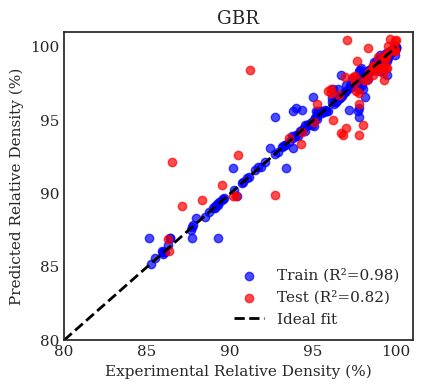

In [63]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11

fig, axes = plt.subplots(1, 1, figsize=(4.5, 4), sharex=True, sharey=True)

ax = axes
ax.scatter(y_train, y_pred_train, label=f"Train (R²={r2_train:.2f})", alpha=0.7, color='blue')
ax.scatter(y_test, y_pred_test, label=f"Test (R²={r2_test:.2f})", alpha=0.7, color='red')
ax.plot([80, 100], [80, 100], 'k--', lw=2, label='Ideal fit')

ax.set_title("GBR")
ax.set_xlabel("Experimental Relative Density (%)")
ax.set_ylabel("Predicted Relative Density (%)")

ax.set_ylim(80, 101)
ax.set_xlim(80, 101)
ax.set_yticks(range(80, 101, 5))
ax.set_xticks(range(80, 101, 5))
ax.legend(loc='lower right')

plt.show()

## RFR

In [67]:
from sklearn.ensemble import RandomForestRegressor
#KERNEL
RFR=RandomForestRegressor(n_estimators=2000,max_depth=20)

#START TRAINING
RFR.fit(X_train,y_train)
#PREDICTION

y_train_pred = RFR.predict(X_train)
y_test_pred = RFR.predict(X_test)

y_pred_train = RFR.predict(X_train)
y_pred_test = RFR.predict(X_test)

MSE_train = MSE(y_train, y_train_pred)
MSE_test = MSE(y_test, y_test_pred)
r2_train = R2(y_train, y_train_pred)
r2_test = R2(y_test, y_test_pred)
mae_train = MAE(y_train, y_train_pred)
mae_test = MAE(y_test, y_test_pred)

print('-'*100)
print(f'Error Metrics')
print(f'Training: MAE={mae_train:.4f}, MSE={MSE_train:.4f}, R2={r2_train:.4f}')
print(f'Testing: MAE={mae_test:.4f}, MSE={MSE_test:.4f}, R2={r2_test:.4f}')
print('-'*100)

----------------------------------------------------------------------------------------------------
Error Metrics
Training: MAE=0.5262, MSE=0.6636, R2=0.9527
Testing: MAE=0.9876, MSE=2.4580, R2=0.8242
----------------------------------------------------------------------------------------------------


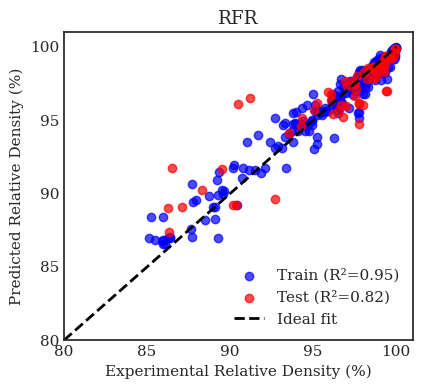

In [69]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11

fig, axes = plt.subplots(1, 1, figsize=(4.5, 4), sharex=True, sharey=True)

ax = axes
ax.scatter(y_train, y_pred_train, label=f"Train (R²={r2_train:.2f})", alpha=0.7, color='blue')
ax.scatter(y_test, y_pred_test, label=f"Test (R²={r2_test:.2f})", alpha=0.7, color='red')
ax.plot([80, 100], [80, 100], 'k--', lw=2, label='Ideal fit')

ax.set_title("RFR")
ax.set_xlabel("Experimental Relative Density (%)")
ax.set_ylabel("Predicted Relative Density (%)")

ax.set_ylim(80, 101)
ax.set_xlim(80, 101)
ax.set_yticks(range(80, 101, 5))
ax.set_xticks(range(80, 101, 5))
ax.legend(loc='lower right')

plt.show()

## Comparisson

In [72]:
import seaborn as sns
sns.set()

y1=xgbr.predict(X_test)
y2=GBR.predict(X_test)
y3=RFR.predict(X_test)

#Plots
#sns.set_theme(style="whitegrid")
#sns.set_theme(style="darkgrid")
plt.rcParams["axes.grid"] = True
fig = plt.figure()
fig.set_size_inches((9,6))
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

plt.plot(y_train, y_star_train, 'mx', label = 'Train')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.plot(y_test, y1, 'rs', label = 'XGBR')
plt.plot(y_test, y2, 'g^', label = 'GBR')
plt.plot(y_test, y3, 'yp', label = 'RFR')

plt.legend()
plt.ylabel('Predicted microhardness (HV)')
plt.xlabel('Measured microhardness (HV)')
#plt.title("Machine learning regressors")
print()



NameError: name 'y_star_train' is not defined

<Figure size 900x600 with 0 Axes>

### CROSS-VALIDATION

In [73]:

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score as CV

import warnings
warnings.filterwarnings('ignore')

models = [ xgbr,  GBR,  RFR ]
labels = ['XGBR',  'GBR',  'RFR']
IMS = []

print("--------------------------------------------------------------")
print("%5s | %5s | %5s | %5s | %5s " % ("ML algorithm",  "CV-R2", "CV-MSE", "CV-MAE", "IM"))
print("--------------------------------------------------------------")

for mod, label in zip( models, labels):
  #y_star = mod.predict(X)

  scoreR2 = CV(mod, X_train, y_train, cv=5, scoring='r2')
  #print(-1*scoreR2)
  scoreMSE = CV(mod, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
  #print(-1*scoreMSE)
  scoreMAE = CV(mod, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
  #print(-1*scoreMAE)
  IM=np.sqrt(((1-scoreR2)**2) + (scoreMSE) + (scoreMAE**2) )
  #print("IM: ", IM)


  print("%15s | %.4f | %.4f | %.4f | %.4f " % (label,  scoreR2.mean(), -1*scoreMSE.mean(), -1*scoreMAE.mean() , np.sqrt(((1-scoreR2.mean())**2) + (-1*scoreMSE.mean()) + (scoreMAE.mean()**2) )))
print("--------------------------------------------------------------")

--------------------------------------------------------------
ML algorithm | CV-R2 | CV-MSE | CV-MAE |    IM 
--------------------------------------------------------------
           XGBR | 0.7027 | 4.0119 | 1.2998 | 2.4062 
            GBR | 0.6705 | 4.5120 | 1.3965 | 2.5633 
            RFR | 0.7103 | 3.9715 | 1.2959 | 2.3948 
--------------------------------------------------------------


# Deep learning

In [ ]:
!pip install -q "tqdm>=4.36.1"
!pip install tensorflow-addons

In [ ]:
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0


In [ ]:
import math
from sklearn import preprocessing
import tensorflow_addons as tfa
from sklearn.inspection import permutation_importance

ModuleNotFoundError: No module named 'keras.src.engine'

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import regularizers
import tensorflow_addons as tfa

ModuleNotFoundError: No module named 'keras.wrappers'